In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
eke_aviso = xr.open_dataarray('data/EKE_aviso.nc')
eke_aviso

<xarray.DataArray (latitude: 720, longitude: 1440)>
[1036800 values with dtype=float64]
Coordinates:
    crs        int32 ...
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [15]:
cm2_per_m2 = 100*100
eke_cesm = xr.open_dataarray('data/eke_cesm.nc') / cm2_per_m2
eke_cesm

<xarray.DataArray (nlat: 2400, nlon: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Dimensions without coordinates: nlat, nlon

In [23]:
# forgot to save coords with cesm
import intake
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
ds = cat["CESM_POP_hires_control"].to_dask().reset_coords()

In [24]:
eke_cesm.coords['lon'] = ds['ULONG'].where(ds.ULONG != -1).reset_coords(drop=True)
eke_cesm.coords['lat'] = ds['ULAT'].where(ds.ULAT != -1).reset_coords(drop=True)

In [4]:
ds_gdp = xr.open_dataset('data/EKE_gdp.nc')
eke_gdp = ds_gdp['EKE'] / cm2_per_m2
eke_gdp

<xarray.DataArray 'EKE' (lat: 160, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.01639014, 0.01330912, 0.01545635, ..., 0.03026538, 0.02582394,
        0.02718192],
       [0.02437417, 0.01859679, 0.02286326, ..., 0.03958118, 0.02821168,
        0.02555262],
       [0.0323223 , 0.04305994, 0.04052465, ..., 0.02730466, 0.02070446,
        0.02659908]])
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 -75.5 ... 76.5 77.5 78.5 79.5

In [5]:
proj = ccrs.EckertIV(central_longitude=180)
norm = LogNorm(vmin=0.001, vmax=1)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


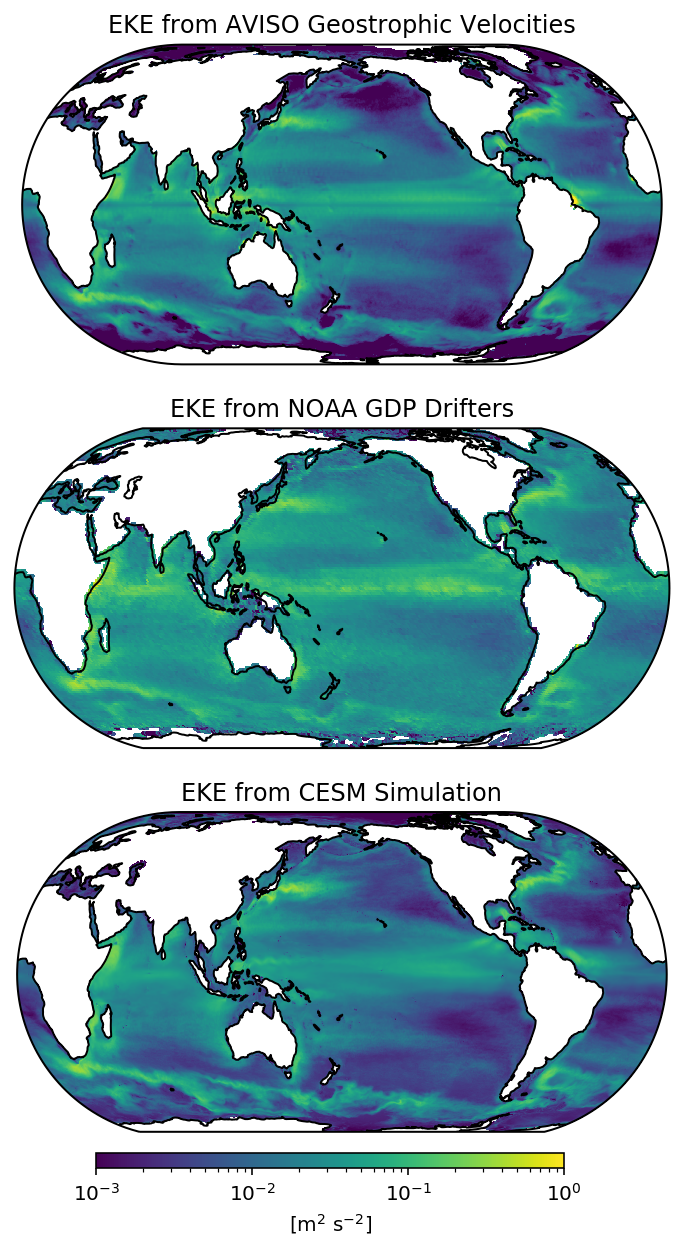

In [56]:
fig, axes = plt.subplots(figsize=(6.5, 10), nrows=3,
                       subplot_kw=dict(projection=proj))

### AVISO
ax = axes[0]
ax.coastlines()
pc = eke_aviso.plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm,
                    add_colorbar=False, rasterized=True)
ax.set_title('EKE from AVISO Geostrophic Velocities')

### GDP
ax = axes[1]
ax.coastlines()
pc = eke_gdp.plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm,
                  add_colorbar=False, rasterized=True)
pc.set_edgecolor('face')
ax.set_title('EKE from NOAA GDP Drifters')

### CESM
ax = axes[2]
ax.coastlines()
pc = ax.pcolormesh(lon_pop_fixed, lat_pop, eke_cesm.where(mask_pop),
                   transform=ccrs.PlateCarree(), norm=norm,
                   rasterized=True)
ax.set_title('EKE from CESM Simulation')

cax = fig.add_axes([0.25, 0.1, 0.5, 0.01])
plt.colorbar(pc, cax=cax,  orientation='horizontal',
             label=r'[m$^2$ s$^{-2}$]')

#plt.tight_layout()
plt.savefig('figures/EKE_comparison.pdf')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


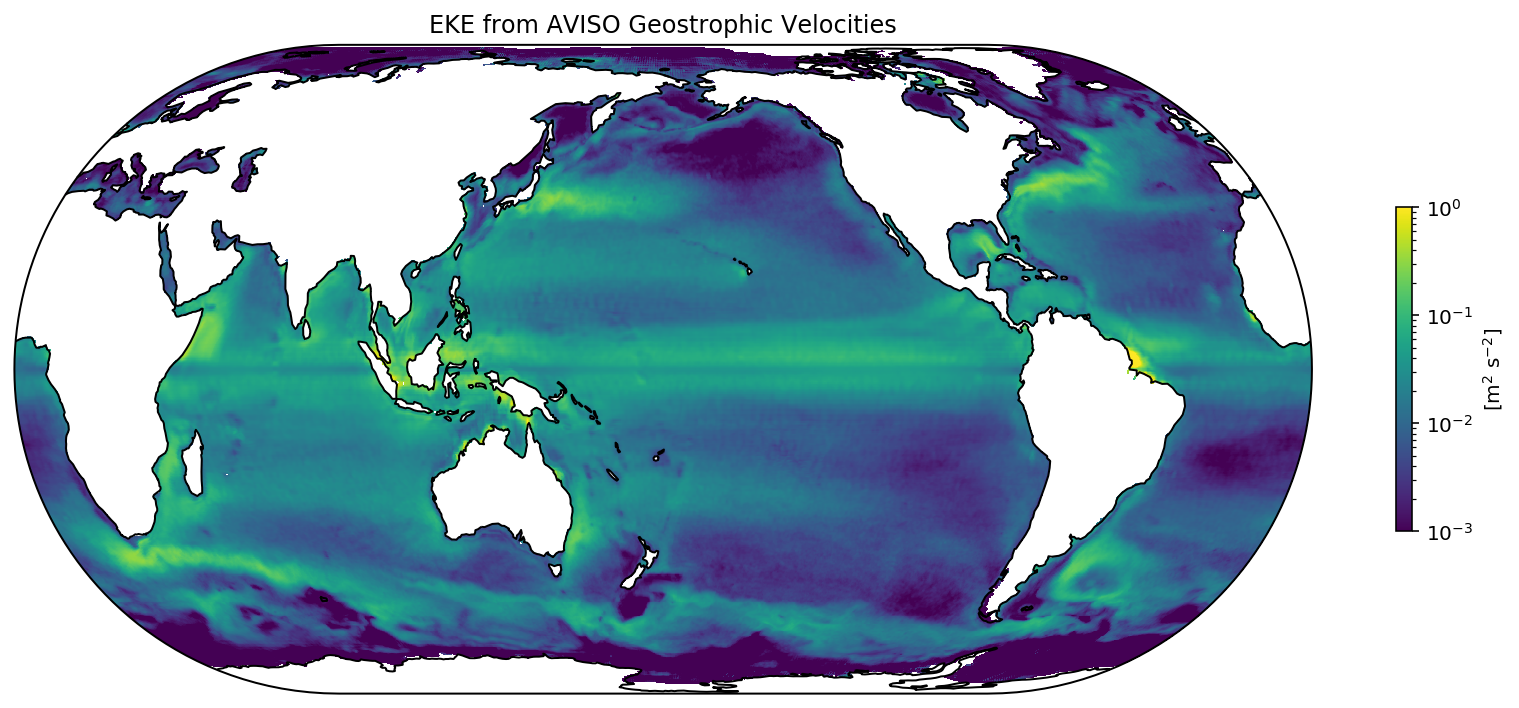

In [42]:
plt.figure(figsize=(12, 5))
ax = plt.axes(projection=proj)
ax.coastlines()
pc = eke_aviso.plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm,
                    add_colorbar=False, rasterized=True)
plt.colorbar(pc, shrink=0.5, label=r'[m$^2$ s$^{-2}$]')
ax.set_title('EKE from AVISO Geostrophic Velocities')
plt.tight_layout()
plt.savefig('figures/EKE_aviso.pdf')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


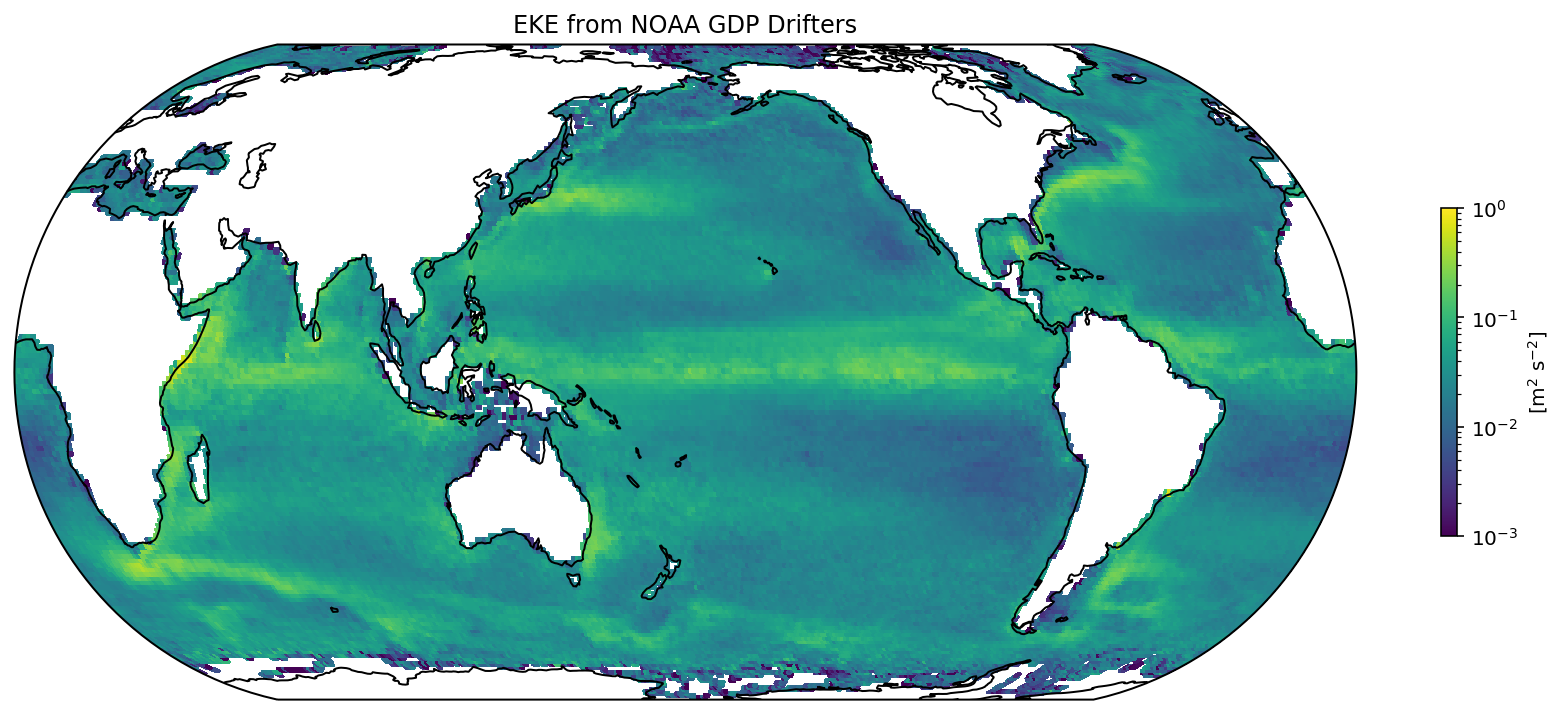

In [45]:
plt.figure(figsize=(12, 5))
ax = plt.axes(projection=proj)
ax.coastlines()
pc = eke_gdp.plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm,
                  add_colorbar=False, rasterized=True)
pc.set_edgecolor('face')
plt.colorbar(pc, shrink=0.5, label=r'[m$^2$ s$^{-2}$]')
ax.set_title('EKE from NOAA GDP Drifters')
plt.tight_layout()
plt.savefig('figures/EKE_gdp.pdf')

In [31]:
from skimage.morphology import dilation, erosion, disk

lon_pop =  ds.ULONG.reset_coords(drop=True)
lat_pop =  ds.ULAT.reset_coords(drop=True)
lon_pop_fixed = lon_pop.values.copy()
lon_pop_fixed[lon_pop_fixed <= lon_pop_fixed[50, -1]] +=360

mask_pop = ds.UAREA > 0
mask_pop.data = erosion(mask_pop, selem=disk(6)) & (ds.KMU>1)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


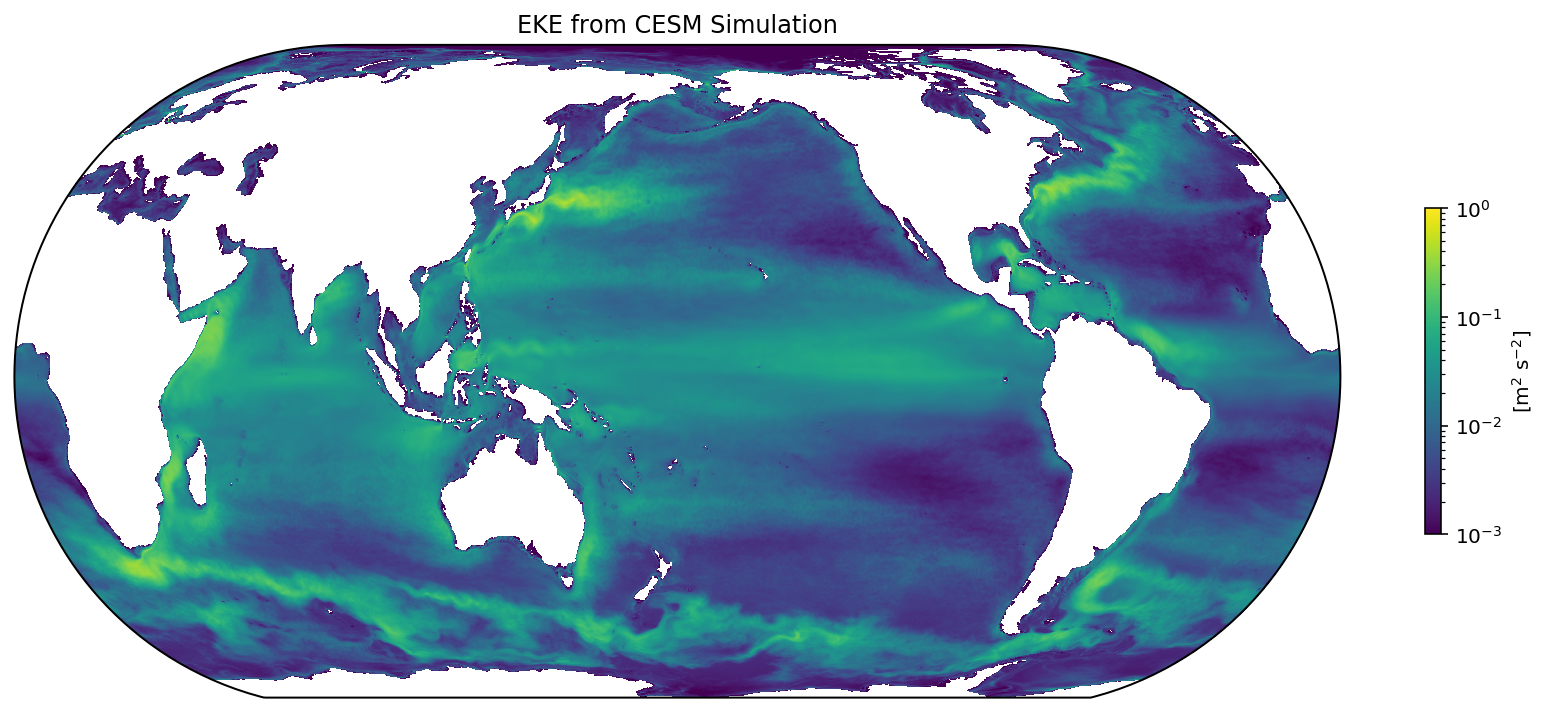

In [44]:
plt.figure(figsize=(12, 5))
ax = plt.axes(projection=proj)
pc = ax.pcolormesh(lon_pop_fixed, lat_pop, eke_cesm.where(mask_pop),
                   transform=ccrs.PlateCarree(), norm=norm,
                   rasterized=True)
plt.colorbar(pc, shrink=0.5, label=r'[m$^2$ s$^{-2}$]')
ax.set_title('EKE from CESM Simulation')
plt.tight_layout()
plt.savefig('figures/EKE_cesm.pdf')